In [3]:
!pip3 install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 5.5 MB/s eta 0:00:00a 0:00:01


In [44]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [33]:
observation, info = env.reset(seed=42)
for _ in range(10000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [34]:
observation.shape

(4,)

In [388]:
class replay_memory(Dataset):
    def __init__(self):
        self.state_0 = []
        self.state_1 = []
        self.reward = []
        self.action = []

    def append_(self,state0, state1, reward, action):
        self.state_0.append(state0)
        self.state_1.append(state1)
        self.reward.append(reward)
        self.action.append(action)

    def __len__(self):
        return len(self.state_0)

    def __getitem__(self,idx):
        return (self.state_0[idx],self.state_1[idx],
                 self.reward[idx], self.action[idx])
    
    def remove(self):
        self.state_0.pop(0)
        self.state_1.pop(0)
        self.reward.pop(0)
        self.action.pop(0)

    def sample(self, batch_size):
        idx = sorted(np.arange(len(self.state_0)))
        idx_sample = random.sample(idx, batch_size)

        return (torch.tensor([self.state_0[i]for i in idx_sample]),
                torch.tensor([self.state_1[i]for i in idx_sample]),
                torch.tensor([self.reward[i] for i in idx_sample]),
                torch.tensor([self.action[i] for i in idx_sample]))

class qnet(nn.Module):
    def __init__(self,state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.l1 = nn.Linear(state_dim,128)
        self.l2 = nn.Linear(128,128)
        self.l3 = nn.Linear(128,self.action_dim)

        self.activation = nn.ReLU()

    def forward(self,x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

def train(iterations, copy_period, batch_size, discount, random_action_p_start, random_action_p_end, verbose=False):

    target_net = qnet(state_dim=4, action_dim=2)
    policy_net = qnet(state_dim=4, action_dim=2)

    target_net.eval()
    policy_net.train()

    optimizer = optim.AdamW(policy_net.parameters(), lr=1e-4, amsgrad=True)
    Huber = nn.SmoothL1Loss()

    policy_net.load_state_dict(target_net.state_dict())

    replay = replay_memory()
  
    observation, info = env.reset(seed=42)
    stop = 0
    random_action_p = random_action_p_start
    progress = []

    for i in range(iterations):

        random_action_p = random_action_p - (random_action_p_start-random_action_p_end)/iterations

        if random.random()<random_action_p:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = policy_net(torch.tensor(observation).reshape(1,-1))
            action = torch.argmax(q_values).item()

        observation_, reward, terminated, truncated, info = env.step(action)

        # If the episode has ended then we can reset to start a new episode
        if terminated or truncated:
            replay.append_(observation, observation_, 0, action)
            progress.append(i-stop)
            stop = i
            observation, info = env.reset()
        else:
            replay.append_(observation, observation_, reward, action)
            observation = observation_


        if len(replay)>batch_size and i%(batch_size)==0:
            optimizer.zero_grad()
            sample = replay.sample(batch_size)
            out = policy_net(sample[0])

            q_state = out[torch.arange(batch_size), sample[3]]

            with torch.no_grad():
                q_next_state_max, _ = torch.max(target_net(sample[1]),dim=1)

            mask = sample[2]==1

            Loss = Huber(q_state, (sample[2] + discount*q_next_state_max*mask))

            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            Loss.backward()
            optimizer.step()

            if verbose and i%1000==0:
                print(f"iteration: {i}, exploration: {random_action_p:2.3f} loss: {Loss:2.3f}, progress: {sum(progress[-10:])/10}")

        if i%copy_period==0:
            target_net.load_state_dict(policy_net.state_dict())

        if len(replay)>5000:
            replay.remove()
    print(plt.plot(progress))
    plt.show()



iteration: 4000, exploration: 0.770 loss: 0.341, progress: 21.8
iteration: 8000, exploration: 0.740 loss: 0.366, progress: 18.3
iteration: 12000, exploration: 0.710 loss: 0.648, progress: 21.7
iteration: 16000, exploration: 0.680 loss: 0.011, progress: 16.7
iteration: 20000, exploration: 0.650 loss: 0.199, progress: 15.7
iteration: 24000, exploration: 0.620 loss: 0.159, progress: 17.3
iteration: 28000, exploration: 0.590 loss: 0.144, progress: 23.0
iteration: 32000, exploration: 0.560 loss: 0.079, progress: 42.3
iteration: 36000, exploration: 0.530 loss: 0.001, progress: 68.3
iteration: 40000, exploration: 0.500 loss: 0.002, progress: 58.4
iteration: 44000, exploration: 0.470 loss: 0.001, progress: 34.0
iteration: 48000, exploration: 0.440 loss: 0.172, progress: 59.2
iteration: 52000, exploration: 0.410 loss: 0.080, progress: 86.8
iteration: 56000, exploration: 0.380 loss: 0.001, progress: 115.8
iteration: 60000, exploration: 0.350 loss: 0.001, progress: 126.1
iteration: 64000, explora

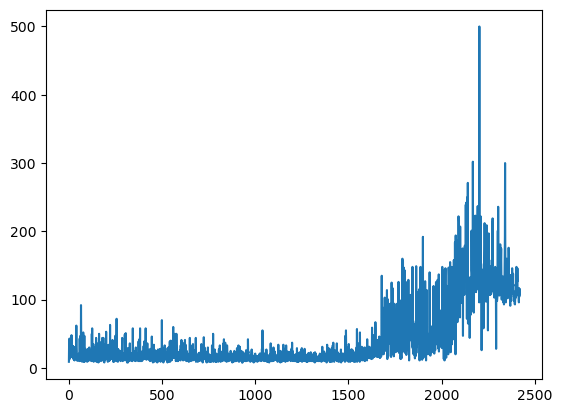

In [390]:
iterations = 100000
copy_period = 50
batch_size = 32
gamma = 0.7
start = 0.8
end = 0.05

train(iterations,copy_period,batch_size,gamma,start,end,True)

In [ ]:
a = torch.randn(10,2)
a


tensor([[-0.2548,  0.2913],
        [ 0.9461, -1.0094],
        [ 0.9972,  0.8844],
        [-2.2006, -1.1497],
        [-0.6361,  0.5999],
        [ 1.2035, -1.0751],
        [ 0.3528,  0.2270],
        [-0.0824, -0.4690],
        [ 1.1741, -0.6472],
        [-0.7847, -0.2118]])

In [228]:
max,idx=torch.max(a,dim=1)

In [229]:
max

tensor([ 0.2913,  0.9461,  0.9972, -1.1497,  0.5999,  1.2035,  0.3528, -0.0824,
         1.1741, -0.2118])

In [ ]:
A, B = 10, 5
x = torch.randn(A, B)
print(x)
idx = torch.randint(0, B, (A,))
print(idx)

x[torch.arange(A), idx]

tensor([[ 3.0680,  0.8286,  0.1104,  1.4454, -2.4611],
        [-0.0837, -1.2076, -0.5256,  0.2018,  0.5592],
        [ 0.7829,  0.5252,  1.0224, -0.4959, -0.3781],
        [-0.3049, -0.0706,  1.0762, -0.4705, -0.9339],
        [-0.5046,  0.3974,  0.3418, -1.3537,  0.5515],
        [ 1.1792, -0.3060,  0.8748, -2.1026, -1.6383],
        [ 0.1405,  1.3074,  0.8414,  2.1613,  1.3371],
        [-0.7136, -0.1475, -0.5759,  0.9557, -0.4512],
        [ 0.3925, -1.6516, -0.9692, -0.0233, -0.8047],
        [-0.4548,  0.0474,  1.8897,  0.0146,  0.7570]])
tensor([1, 0, 3, 2, 4, 0, 2, 2, 2, 4])


tensor([ 0.8286, -0.0837, -0.4959,  1.0762,  0.5515,  1.1792,  0.8414, -0.5759,
        -0.9692,  0.7570])

In [56]:
d.dataset.append(1,1,1,1)

In [ ]:
random.sample(sorted(np.arange(10)),5)

TypeError: list indices must be integers or slices, not list